## Advanced Numerical  Methods in Many-Body Physics
# Exercise 9
### Jesse Hoogland 

--- 
I added only one new method to `heisenberg.py` since exercise 7 (to get the energy of an arbitrary state with `get_energy`). 

## Imports

In [1]:
import os
import sys

import numpy as np
from scipy.linalg import diagsvd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from tensor_networks import *  
from heisenberg import *

# Keep 3 digits of accuracy, and avoid scientific notation when possible.
np.set_printoptions(precision=3, suppress=True, threshold=5) 

# 9.1 Introduction to tensor network operations

## 9.1.1 Compare matrix and 4-tensor representations of the 2-site spin-1/2 Heisenberg system.


In [2]:
S_z = np.array([[1.,0],[0, -1.]])/2.
S_plus = np.array([[0,1.],[0,0]])
S_minus = np.array([[0,0],[1.,0]])

In [3]:
hamiltonian_matrix_form = np.kron(S_z, S_z) + (np.kron(S_plus, S_minus)+np.kron(S_minus,S_plus))/2
hamiltonian_4_tensor_form = np.reshape(hamiltonian_matrix_form, [2,2,2,2])

print("Heisenberg hamiltonian in matrix form:\n{}".format(hamiltonian_matrix_form))
print("Heisenberg hamiltonian in 4-tensor form:\n{}".format(hamiltonian_4_tensor_form))

Heisenberg hamiltonian in matrix form:
[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]
Heisenberg hamiltonian in 4-tensor form:
[[[[ 0.25  0.  ]
   [ 0.    0.  ]]

  [[ 0.   -0.25]
   [ 0.5   0.  ]]]


 [[[ 0.    0.5 ]
   [-0.25  0.  ]]

  [[ 0.    0.  ]
   [ 0.    0.25]]]]


Indeed, the elements of $\hat S_1^z \hat S_2^z$ are where we expect them to be: each 2 by 2 innermost nestled matrix in the 4-tensor matrix corresponds to one the columns of the matrix form. These act, in order, on $|\uparrow\uparrow\rangle,|\uparrow\downarrow\rangle,|\downarrow\uparrow\rangle,|\downarrow\downarrow\rangle$, 

## 9.1.2 Compare vector and matrix representations of the ground state of the 2-state spin-1/2 Heisenberg system.

![Tensor network](./img/tensor_network_heisenberg.png)

In [4]:
eig_vals, eig_vecs = np.linalg.eigh(hamiltonian_matrix_form)  

ground_state_vec_form = eig_vecs[:,0]
ground_state_matrix_form = np.reshape(ground_state_vec_form, [2,2])

print("Eigenvalue spectrum:\n{}\nwith corresponding eigenvectors:\n{}".format(eig_vals, eig_vecs))
print("\nGround state in vector form:\n{}".format(ground_state_vec_form))
print("Ground state in matrix form:\n{}".format(ground_state_matrix_form)) 


Eigenvalue spectrum:
[-0.75  0.25  0.25  0.25]
with corresponding eigenvectors:
[[ 0.     1.     0.     0.   ]
 [ 0.707  0.     0.707  0.   ]
 [-0.707  0.     0.707  0.   ]
 [ 0.     0.     0.     1.   ]]

Ground state in vector form:
[ 0.     0.707 -0.707  0.   ]
Ground state in matrix form:
[[ 0.     0.707]
 [-0.707  0.   ]]


## 9.1.3 Draw the Tensor network diagrams (and calculate) for the norm and energy of the ground state in the matrix representation

In [5]:
ground_state_norm = np.tensordot(ground_state_matrix_form, 
                                 ground_state_matrix_form)
 
print("The ground state should have unit norm. It has norm {}.".format(ground_state_norm))

ground_state_energy_true = eig_vals[0]

ground_state_energy = np.tensordot(ground_state_matrix_form,
                                 np.tensordot(hamiltonian_4_tensor_form,
                                              ground_state_matrix_form,
                                 ))

print("The ground state should have energy {}. It has energy {}".format(ground_state_energy_true, ground_state_energy))


The ground state should have unit norm. It has norm 1.0.
The ground state should have energy -0.75. It has energy -0.75


## 9.1.4 Transpose the indices and see what changes

In [6]:
ground_state_matrix_form_T = np.transpose(ground_state_matrix_form)

ground_state_norm_T = np.tensordot(ground_state_matrix_form_T, 
                                   ground_state_matrix_form_T)
 
print("The transposed ground state has norm {}.".format(ground_state_norm_T))

ground_state_energy_T = np.tensordot(ground_state_matrix_form_T,
                                 np.tensordot(hamiltonian_4_tensor_form,
                                              ground_state_matrix_form_T,
                                 ))

print("The transposed ground state has energy {}".format(ground_state_energy_T))


The transposed ground state has norm 1.0.
The transposed ground state has energy -0.75


As we might expect, so long as we change both of the indices in tandem, nothing is changed. 

### Check that the Hamiltonian is Hermitian

In [7]:
print("The original Hamiltonian is:\n{}\n\nand the transposed Hamiltonian is:\n{}".format(hamiltonian_4_tensor_form, np.transpose(hamiltonian_4_tensor_form)))

The original Hamiltonian is:
[[[[ 0.25  0.  ]
   [ 0.    0.  ]]

  [[ 0.   -0.25]
   [ 0.5   0.  ]]]


 [[[ 0.    0.5 ]
   [-0.25  0.  ]]

  [[ 0.    0.  ]
   [ 0.    0.25]]]]

and the transposed Hamiltonian is:
[[[[ 0.25  0.  ]
   [ 0.    0.  ]]

  [[ 0.   -0.25]
   [ 0.5   0.  ]]]


 [[[ 0.    0.5 ]
   [-0.25  0.  ]]

  [[ 0.    0.  ]
   [ 0.    0.25]]]]


A quick glance reveals them to be the same, so the Hamiltonian is, indeed, Hermitian.

# 9.2 Schmidt Decomposition and Entanglement entropy

## 9.2.1 Ground state of 16-site spin-1/2 Heisenberg chain with open boundaries

In [8]:
heisenberg = HeisenbergSpinHalf(n_spins=16, mode="sparse")
ground_state_energy, ground_state = heisenberg.diagonalize(verbose=False, n_eigvals=1)
ground_state_energy = ground_state_energy[0]

## 9.2.2 Entanglement entropy and eigenvalue distribution of reduced density matrix across middle split

In [9]:
ground_state_matrix = ground_state.reshape([2**8,2**8])

In [10]:
u, singular_vals, v = np.linalg.svd(ground_state_matrix,full_matrices=False, compute_uv=True)

In [11]:
get_von_neumann_entropy = lambda probs: np.sum(-probs * np.log(probs))

eig_vals = np.square(singular_vals) 
von_neumann_entropy = get_von_neumann_entropy(eig_vals)
norm_eig_vals = eig_vals / np.sum(eig_vals)

print("The Von Neumann entropy of the ground state is: {}".format(von_neumann_entropy ))

The Von Neumann entropy of the ground state is: 0.592307034077


The eigenvalue distribution is displayed below.
## 9.2.3 Random state entanglement entrorpy and eigenvalue distribution

In [12]:
def create_random_state(n_spins):
    random_state_unnormed = np.random.uniform(low=-1., high=1., size= 2**n_spins)
    return random_state_unnormed / np.linalg.norm(random_state_unnormed)


In [13]:
random_state = create_random_state(16)
random_state_matrix = random_state.reshape([2**8,2**8])
random_u, random_singular_vals, random_v = np.linalg.svd(random_state_matrix, full_matrices=False)
random_eig_vals = np.square(random_singular_vals)
random_eig_vals_normed = random_eig_vals / np.sum(random_eig_vals)
random_state_entropy = get_von_neumann_entropy(random_eig_vals_normed)

Text(0,0.5,'Eigenvalue magnitude')

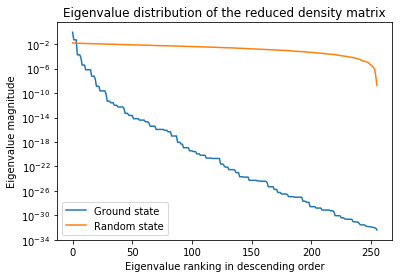

In [14]:
plt.semilogy(np.arange(eig_vals.shape[0]), norm_eig_vals,label="Ground state")
plt.semilogy(np.arange(eig_vals.shape[0]), random_eig_vals_normed, label="Random state")

plt.legend()
plt.title("Eigenvalue distribution of the reduced density matrix")
plt.xlabel("Eigenvalue ranking in descending order")
plt.ylabel("Eigenvalue magnitude")

In [15]:
def get_energy(hamiltonian, state):
    state = state.reshape([np.prod(state.shape), 1])
    res = np.dot((state.T * hamiltonian), state)
    assert res.shape == (1,1)
    return res[0,0]
    

get_heisenberg_energy = lambda s: get_energy(heisenberg.hamiltonian, s)

get_heisenberg_energy(ground_state)

-6.911737145575108

### What do you observe?
We see that the ground state decreases much more rapidly (seemingly exponentially) than the random state, which has dominant "activations" across a large number of modes. No single one of the random state's components is considerably more likely than any of the others.

In [16]:
def expectation_val_scaling(observable_fn, probs, U, V, n_samples):
    """
    Computes the weighted sum of ``observable_fn`` over ``states`` according to 
    weights ``probs``. Computes a weighted sum of up to ``n_samples``.
    
    Returns an array of length ``n_samples``, each index i corresponding to 
    the value resulting from computing expectation of up to the i most probable states.
    """
    expectations= np.zeros(n_samples)
    cumulative_sum = 0
    cumulative_prob = 0
    
    for i in range(0,n_samples):
        ith_contrib = get_heisenberg_energy(sp.kron(U[:,i], V.T[:, i] , "csr").T)
        #print(ith_contrib)
        cumulative_sum += ith_contrib * probs[i]
        cumulative_prob += probs[i]
        expectations[i] = cumulative_sum / cumulative_prob
        
    return expectations

In [17]:
ground_state_energy_scaling = expectation_val_scaling(get_heisenberg_energy, eig_vals, u, v, 100)

In [18]:
random_energy_scaling = expectation_val_scaling(get_heisenberg_energy, random_eig_vals, random_u, random_v, 100)

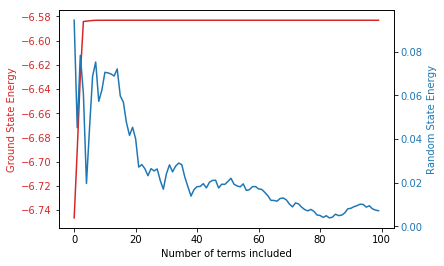

In [19]:

fig, ax1 = plt.subplots()
color1 = "tab:red"
ax1.set_xlabel('Number of terms included')
ax1.set_ylabel('Ground State Energy', color=color1)
ax1.plot(np.arange(ground_state_energy_scaling.size), ground_state_energy_scaling, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = "tab:blue"
ax2 = ax1.twinx()
ax2.set_ylabel('Random State Energy', color=color2)
ax2.plot(np.arange(random_energy_scaling.size), random_energy_scaling,color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

Upon comparing the ground state energy approximation with the explicit calculation (see exercise 7), we can check that our code is working correctly.

### Observations on convergence of estimate
Indeed, the ground state energy converges to the right answer within 5 or so terms. On the other hand, the random state energy has a drift-diffusion kind of quality, oscillating regularly, and not even converging within the first 100 samples

# 9.3 Decomposition of a state into an MPS using SVDs

## 9.3.1. Function to decompose an arbitrary state into an MPS

In [47]:
def decompose_to_mps(state, max_bond_dim=None):
    """
    @param state: is a np.ndarray of shape [2**n_sites]
    """

    n_sites = int(np.log2(state.size)) # First we try with 4

    if max_bond_dim is None: 
        # If the user doesn't specify a max_bond_dim, then any dimension is allowed
        # And we can recreate the state exactly.
        max_bond_dim = 2**(n_sites//2)

    mps = []
    prev_u_dim = 1
        
    for i in range(n_sites-1):
        state = state.reshape((2*prev_u_dim, -1)) 
        
        # FULL BOND DIMENSION [2, 4, 8, 16 ... 16, 8, 4, 2]
        # This would preserve the state in its entirety
        if (i < n_sites / 2): 
            full_bond_dim = 2 ** (i+1)
        else:
            full_bond_dim = 2 ** (n_sites - i)
                    
        # Perform the SVD
        u, s, v = np.linalg.svd(state, full_matrices=False)
        # state with shape [l, r]
        # u with shape [l, k]
        # s with shape k := min(l, r)
        # v with shape [k, r]

        # CONSTRAIN IF MAXIMUM ALLOWED DIMENSION < FULL REQUIRED DIMENSION
        # This amounts to changing k -> max_bond_dimension
        if max_bond_dim < full_bond_dim:
            # If our max_bond_dim is less than the full bond dimension
            # required to perfectly encode the state, then we need to 
            # "trim" our u, s, and v matrices
            
            u = u[:, :max_bond_dim]
            s = s[:max_bond_dim]
            v = v[:max_bond_dim, :]
        
        # RESHAPE U DEPENDING ON BOUNDARY CONDITIONS
        # Depending on whether we are at boundary sites or in the chain, 
        # we will need 2 or 3 indices, respectively.
        if (i == 0 or i == n_sites-1): 
            u = u.reshape([2, 2])
            #elif (n_sites % 2 == 1 and i == n_sites // 2): # Middle site
            #    u = u.reshape([prev_u_dim, 2, prev_u_dim])
        else: 
            u = u.reshape([prev_u_dim, 2, -1])
              
        # The first axis on the next U has the same shape as the last axis of the current U
        prev_u_dim = u.shape[-1]

        # We add our U to the matrix product state list
        # This is a list because the U's can have different numbers of indices
        mps.append(u)
        state = np.dot(np.diag(s), v)
        
    mps.append(state)
            
    return mps

## 9.3.2 Function to recompute state as vector from MPS


In [48]:
def vector_from_mps(mps):
    vec = mps[0]

    for site in mps[1:]:
        vec = np.tensordot(vec, site, axes=[[-1], [0]])

    vec = vec.reshape([-1])
    norm = 1 #vec.dot(vec)
    
    return vec / np.sqrt(norm)

### Checking that 9.3.1 and 9.3.2 are implemented correctly

In [49]:

def test_mps_encoding_decoding(state_vec, n_spins):
    print("Original state of {} spins in vector form:".format(n_spins))
    print(state_vec)
    
    state_mps = decompose_to_mps(state_vec)

    print("MPS state shapes {}".format([mps.shape for mps in state_mps]))
    state_vec_reconstructed = vector_from_mps(state_mps)
    print("\nReconstruction of vector form from MPS form:")
    print(state_vec_reconstructed)
        
    heisenberg = HeisenbergSpinHalf(n_spins=n_spins, mode="sparse")
    original_energy = get_energy(heisenberg.hamiltonian, state_vec)
    reconstructed_energy = get_energy(heisenberg.hamiltonian, state_vec_reconstructed)
    print("\nOriginal energy: {} and reconstructed energy: {}".format(original_energy, reconstructed_energy))
    
    if np.isclose(original_energy, reconstructed_energy):
        print("\n✅")
    else:
        print("\n❌")

print("\n----------------------------------------------\n")
print("Testing with a random state on {} spins.\n".format(3))
test_mps_encoding_decoding(create_random_state(3), 3)

print("\n----------------------------------------------\n")
print("Testing with a random state on {} spins.\n".format(4))
test_mps_encoding_decoding(create_random_state(4), 4)

print("\n----------------------------------------------\n")
print("Testing with the ground state on {} spins.\n".format(6))
heisenberg_6 = HeisenbergSpinHalf(n_spins=4, mode="sparse")
ground_state_6 = heisenberg_6.diagonalize(verbose=False, n_eigvals=1)[1].T[0]
test_mps_encoding_decoding(ground_state_6, 4)


----------------------------------------------

Testing with a random state on 3 spins.

Original state of 3 spins in vector form:
[-0.167  0.283  0.265 ... -0.434 -0.608  0.512]
MPS state shapes [(2, 2), (2, 2, 2), (2, 2)]

Reconstruction of vector form from MPS form:
[-0.167  0.283  0.265 ... -0.434 -0.608  0.512]

Original energy: 0.3633483769 and reconstructed energy: 0.3633483769

✅

----------------------------------------------

Testing with a random state on 4 spins.

Original state of 4 spins in vector form:
[-0.153 -0.007  0.251 ... -0.448  0.136 -0.155]
MPS state shapes [(2, 2), (2, 2, 4), (4, 2, 2), (2, 2)]

Reconstruction of vector form from MPS form:
[-0.153 -0.007  0.251 ... -0.448  0.136 -0.155]

Original energy: -0.277572831448 and reconstructed energy: -0.277572831448

✅

----------------------------------------------

Testing with the ground state on 6 spins.

Original state of 4 spins in vector form:
[-0. -0. -0. ...  0. -0. -0.]
MPS state shapes [(2, 2), (2, 2, 4)

## 9.3.3 Approximate decomposition of ground state as MPS with a given maximal bond dimension. Analyze error.

In [68]:
def mps_error_scaling(state, n_spins, max_bond_dim_range=np.array([2, 3, 4, 5, 8, 16, 32, 35,
                                                                   40, 48, 64, 100]), plot=True):
    energy_errors = np.zeros(max_bond_dim_range.size)
    
    heisenberg = HeisenbergSpinHalf(n_spins=n_spins, mode="sparse")
    energy_true = heisenberg.get_energy(state)
    
    for i, max_bond_dim in enumerate(max_bond_dim_range):
        state_approx = vector_from_mps(decompose_to_mps(state, max_bond_dim))
        energy_approx = heisenberg.get_energy(state_approx)
        energy_errors[i] = (energy_approx-energy_true)** 2 / energy_true**2
        
    if plot:
        plt.semilogy(max_bond_dim_range, energy_errors)
        plt.ylabel("Error (logarithmic)")
        plt.xlabel("Maximum Bond Dimension")
        
    return energy_errors
    

MPS approximation accuracy with maximum bond dimension for a 10 spin-1/2 Heisenberg chain.


array([0.084, 0.025, 0.   , ..., 0.   , 0.   , 0.   ])

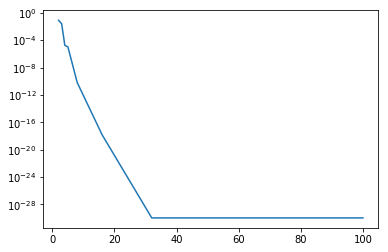

In [70]:
heisenberg_10 = HeisenbergSpinHalf(n_spins=10)
ground_state_10 = heisenberg_10.diagonalize(verbose=False, n_eigvals=1)[1].T

print("MPS approximation accuracy with maximum bond dimension for a 10 spin-1/2 Heisenberg chain.")
mps_error_scaling(ground_state_10, 10) 

# 9.4 Computational cost to contract a tensor network

## 9.4.a

Leading order: $O(D^6)$

![](./img/9.4.a.png)

## 9.4.b

Leading order: $O(D^4)$

![](./img/9.4.b.png)

Note: the sub-optimal first contraction would have been $AB$ (with order $O(D^5)$. It would have been equivalently optimal to first contract $CB$.

## 9.4.c

Leading order: $O(D^6)$

![](./img/9.4.c.png)
 
Note: all other possible choices of first contraction are sub-optimal, already exceeding order $O(D^6)$.

# 9.5 Drawing tensor network diagrams

## 9.5.1 $\quad\hat O_{45}$

![](./img/9.5.1.png)

## 9.5.2 $\quad\hat\rho_{456}=\text{Tr}_{123}\hat\rho$

![](./img/9.5.2.png)

## 9.5.3 $\quad \hat O_2 \hat O_4$

This can be reduced to leading order $O(D^4)$.

![](./img/9.5.3.png)